# Classement automatique de textes par réseau de neurones

L’objectif de ce TP est de développer un modèle de prédiction de fakenews à partir d’un apprentissage automatique par réseau de neurones et d'une représentation en sac de mots (bag of words).

## Ensemble de données 
Le tp utilisera un ensemble de données issues du site de dépôt de dataset [Kaggle](https://www.kaggle.com/datasets).

Plus précisément, vous utiliserez le dataset ["Fake News Dataset"](https://www.kaggle.com/datasets/pnkjgpt/fake-news-dataset).

Ce dataset contient des exemples de news classées en tant que réelles et fausses.

Deux jeux de données sont proposés : un ensemble d'[exemples d'entrainement](train.csv) et un ensemble d'[exemples de tests](test.csv) mais sans label, donc a priori inutiles.


---
Si vous utisez colab, vous devrez charger vos fichiers de données dans votre Drive Google.

Pour pouvoir les utiliser, il vous faut monter le répertoir drive pour qu'il soit accessible par colab.
Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [ ]:
#bloc à exécuter si vous utilisez colab
from google.colab import drive, files

drive.mount('/content/drive')

---
## Préparation des données


### Creations des fichiers de données

A partir du fichier contenant les tables, vous devez créer 2 fichiers texte. 
L'un contenant les news classées reelles (reellesnews.txt par exemple) et l'autre news classees fake (fakenews.txt par exemple).



### Réduction des exemples
Le nombre de mots utilisés le vocabulaire, étant assez vaste; on le réduit dans un premier temps

### Création du vocabulaire utile

En chargeant l'ensemble des lignes contenues dans les fichers texte, on crée un vocabulaire des mots utiles en :   
  - identifiant les termes (**tokens**) entre espaces,
  - supprimant toute ponctuation,
  - supprimant tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimant tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimant tous les mots dont la longueur est <= 2 caractères (par exemple)

### Chargement et nettoyage des données

Il convient pour chaque fichier texte de créer le  
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimer tous les mots dont la longueur est <= 2 caractères (sauf IA, AI)



### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichier, ainsi qu'à la bibliothèque nltk et aux bibliothèques spécialisées dans le traitement de texte.. : 

In [4]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing
from numpy import array, zeros


2022-12-12 00:49:50.462298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
rep = '/Users/.../.../' ## ICI VOTRE REPERTOIRE DE TRAVAIL
# le code suivant charge l'ensemble des mots non importants 
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmanueladam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Fonctions de lectures et d'"épurage" de fichier texte

In [34]:
def load_doc(filename:str)->list:
    """retourne les lignes de texte du fichier filename"""
    # open the file as read only
    with open(filename) as file:
        text = file.read().splitlines() 
    return text

 
def clean_doc(doc)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words anglais et francais
    retire d autres mots cles comme 'vers', 'lors' , .."""
    tokens = doc.lower()
    tokens = tokens.split()
    # A CONTINUER .......!!!!!!
    return tokens


### Tests de la récupération de mots clés d'un fichier

In [37]:
def test_recup():
    # mots clés du fichier des news reelles
    filename = rep + '/reellesnews.txt'
    lines = load_doc(filename)
    text = ' '.join(lines)
    tokens = clean_doc(text)
    print('les 10 premiers mots cles de ', filename)
    print(tokens[:10])
    # mots clés du fichier des fake news
    filename = rep + '/fakenews.txt'
    lines = load_doc(filename)
    text = ' '.join(lines)
    tokens = clean_doc(text)
    print('les 10 premiers mots cles de ', filename)
    print(tokens[:10])    

In [38]:
test_recup()

les 10 premiers mots cles de  /Users/emmanueladam/Documents/GitHub/IntelligenceArtificiellePython//reellesnews.txt
['reuter', 'reporter', 'love', 'reuter', 'voter', 'rallie', 'voter', 'politic', 'democrat', 'election']
les 10 premiers mots cles de  /Users/emmanueladam/Documents/GitHub/IntelligenceArtificiellePython//fakenews.txt
['democrat', 'allie', 'voter', 'senator', 'admission', 'protect', 'worker', 'taxpayer', 'arkansa', 'republican']


### Construire le vocabulaire global

In [39]:
def add_doc_to_vocab(filename, vocab):
    """cumule dans la liste vocab les mots du fichier filename 
    (1 seule occurence par mot dans vocab)"""
    # load doc
    lines = load_doc(filename)
    doc = ' '.join(lines)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def create_global_vocabulary():
    """creer un vocabulaire (liste de mots clés associés à leurs occurences)
    par la suite, un mot d'un texte ne faisant pas partie du vocabulaire ne sera
    pas compte"""
    vocab = Counter()
    # ajouter les mots cles des fichiers
    add_doc_to_vocab(rep+'/reellesnews.txt', vocab)
    add_doc_to_vocab(rep+'/fakenews.txt', vocab)

    # afficher le nb de mots cles trouves
    print("nb de mots cles trouves dans les repertoires : ", len(vocab))
    print("les 10 premiers mots cles du vocabulaire \
    (et leur nb d\'apparition dans les exemples)  : \n", end='')
    i=0
    for (mot,count) in vocab.items(): 
        print(mot,':',count,end=", ")
        i = i+1
        if i>10:break
    # afficher les 10 mots cles les plus utilises
    print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

    # ne garder que les mots clés apparaissant au moins 2 fois
    min_occurrence = 2
    tokens = [token for (token,count) in vocab.items() if count >= min_occurrence]
    print('en otant les mots utilise moins de ', min_occurrence, ' fois,', 
          ' nb de mots cles = ',len(tokens))
    return tokens

In [40]:
## Sauvegarde du vocabulaire
def save_list(lines, filename):
    """sauve les mots de la liste lines dans le fichier filename"""
    # open file
    file = open(filename, 'w')
    data = '\n'.join(lines)
    # write text
    file.writelines(data)
    # close file
    file.close()

In [41]:
## A la 1ere utilisation, et a chaque modification des fichiers de données
tokens = create_global_vocabulary()
save_list(tokens, 'vocabNews.txt')

nb de mots cles trouves dans les repertoires :  4291
les 10 premiers mots cles du vocabulaire     (et leur nb d'apparition dans les exemples)  : 
reuter : 665, reporter : 138, love : 13, voter : 160, rallie : 24, politic : 84, democrat : 238, election : 87, state : 586, time : 164, date : 7, 
les 10 mots cles les plus utilises :  [('reuter', 665), ('state', 586), ('new', 447), ('year', 358), ('republican', 318), ('official', 299), ('say', 266), ('democrat', 238), ('congres', 230), ('member', 207)]
en otant les mots utilise moins de  2  fois,  nb de mots cles =  2391


### Réduction des entrées
Chaque entrée texte peut être maintenant simplifiée. 
Pour chaque entrée, on extrait les tokens qui ne sont pas présents dans le vocabulaire utile.

In [42]:
def filter_line(line, vocab)->list:
    """retourne la liste des mots cles de la ligne appartenant au vocabulaire vocab"""
    # clean line
    tokens = clean_doc(line)    
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

Pour chaque fichier d'exemples, on en retire deux listes de lignes épurées, une liste contenant 90% des exemples, et une autre 10%

In [43]:
def process_train_file(filenametrain, vocab)->list:
    """retourne deux listes des mots cles du repertoire directory; 
    la 1ere liste est issu de 90% du fichier d'entrainement, 
    la 2e du fichier des 10% restant"""
    lines_train = list()
    lines_test = list()
    i=1
    lines = list()
    # load and clean the file
    with open(filenametrain) as file:
        lines = file.read().splitlines()
    filtered_lines = [filter_line(line, vocab) for line in lines]
    ##TODO: 
    # creer lines_train et lines_test
    return (lines_train,lines_test)


In [44]:
# SI le vocabulaire n'a ete cree dans cette session mais avant ALORS le charger
# load the vocabulary
vocab_filename = 'vocabNews.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab)
# load training and testing examples
(positive_lines_train, positive_lines_test) = process_train_file(rep+'/reellesnews.txt', vocab)
(negative_lines_train, negative_lines_test) = process_train_file(rep+'/fakenews.txt', vocab)
# summarize what we have
print("nb exemples d'entrainement positifs : ", len(positive_lines_train))
print("nb exemples d'entrainement negatifs : ", len(negative_lines_train))
print("nb exemples de tests positifs : ", len(positive_lines_test))
print("nb exemples de tests negatifs : ", len(negative_lines_test))

nb exemples d'entrainement positifs :  450
nb exemples d'entrainement negatifs :  449
nb exemples de tests positifs :  51
nb exemples de tests negatifs :  50


---
## Représentation en sac de mots



### Convertir les exemples en vecteurs
Chaque exemple doit être transformé dans un vecteur de même format.
On recrée un vocabulaire des mots présents dans les exemples; puis pour chaque exemple, on crée un vecteur de 0, 1 (1 si le ie mot du vocabulaire existe dans l'exemple).

Ainsi tous les exemples de ligne sont transformés en vecteurs de même dimension.

On utilise pour cela un "Tokenizer"


In [45]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
# build the training doc based on training data
training_doc = list()
training_doc.extend(positive_lines_train)
training_doc.extend(negative_lines_train)
# ask to the tokenizer to build the bag of words : a set of (word, use)*
#-> tokenizer.fit_on_texts(A COMPLETER)

"Il ne reste plus qu'à" demander au 'Tokenizer' de réaliser la transformation des exemples d'entrainement en vecteurs d'entrainement.

In [46]:
xTrain = tokenizer.texts_to_matrix(training_doc, mode='freq')
##TODO: regarder les autres modes que freq; par exemple 'bin', qu'apportent-ils ?
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  899  exemples de  2340  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0.         0.33333333 0.         ... 0.         0.         0.        ]


#### Création des sorties
Les premiers vecteurs représente des exemples positifs. On crée une sortie constituée d'autant de valeurs [1] suivie de valeurs [0]. 

In [47]:
#ytrain = suite de (0 (classement pour eval positive),  1 (classements pour éval négative))
yTrain = zeros(len(positive_lines_train)+len(negative_lines_train))
yTrain[:len(positive_lines_train)] = 1

#### Exemples de test
On ré-itère pour les exemples de test; en réutilisant le même 'Tokenizer'

In [48]:
# build the test doc by alternating positive lines and negative lines
test_Doc = list()
test_Doc.extend(positive_lines_test)
test_Doc.extend(negative_lines_test)
# ask to the tokenizer to give the bag of words : a set of (word, frequence of use),
# the words are already kown by the tokenizer*
xTest = tokenizer.texts_to_matrix(test_Doc, mode='binary')
print('Xtest contient ', xTest.shape[0], ' exemples de ', xTest.shape[1], ' valeurs de fréquence.')

#sortie attendues des exemples de test, ytest = suite de (0, 1)
yTest = zeros(len(positive_lines_test)+len(negative_lines_test))
yTest[:len(positive_lines_test)] = 1

Xtest contient  101  exemples de  2340  valeurs de fréquence.


---
## Modèle de réseau pour l'analyse des theses
Le réseau contient en couche d'entrée aurant de neurones que de tokens retenus. 
Chaque exemple est codé sous forme d'une suite de 0 ou 1, d'une dimension égale au vocabulaire retenu.

xTrain est donc une matrice de n exemples x m colonnes. m étant la dimension des vecteurs d'entrée, c-a-d le nombre de mots finalement pris en comptes, et donc le nombre de neurones de la 1er couche du réseau

In [49]:
# nb de neurones en entrée (= nb de tokens retenus)
## shape[0] est la 1ere dimension d'un tableau (ici le nb d'exemples)
## shape[1] est la 1ere dimension d'un tableau (ici le nb de tokens)
n_words = xTrain.shape[1] 

In [50]:
# TODO: définir la structure du réseau
model = Sequential()
## A VOUS !!!!!
...
...
# compile network 
model.compile(### A VOUS .....




In [51]:
#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, yTrain, 
                    validation_data=(xTest, yTest),
                    epochs=10, verbose=2)

Epoch 1/10
29/29 - 2s - loss: 0.7572 - accuracy: 0.8365 - val_loss: 0.5943 - val_accuracy: 0.9010 - 2s/epoch - 58ms/step
Epoch 2/10
29/29 - 1s - loss: 0.5335 - accuracy: 0.9722 - val_loss: 0.6139 - val_accuracy: 0.8812 - 1s/epoch - 45ms/step
Epoch 3/10
29/29 - 1s - loss: 0.5175 - accuracy: 0.9811 - val_loss: 0.6261 - val_accuracy: 0.8713 - 1s/epoch - 44ms/step
Epoch 4/10
29/29 - 1s - loss: 0.5098 - accuracy: 0.9889 - val_loss: 0.6205 - val_accuracy: 0.8713 - 1s/epoch - 44ms/step
Epoch 5/10
29/29 - 1s - loss: 0.5476 - accuracy: 0.9511 - val_loss: 0.6545 - val_accuracy: 0.8416 - 1s/epoch - 44ms/step
Epoch 6/10
29/29 - 1s - loss: 0.5133 - accuracy: 0.9867 - val_loss: 0.6634 - val_accuracy: 0.8317 - 1s/epoch - 44ms/step
Epoch 7/10
29/29 - 1s - loss: 0.5162 - accuracy: 0.9844 - val_loss: 0.5948 - val_accuracy: 0.9010 - 1s/epoch - 44ms/step
Epoch 8/10
29/29 - 1s - loss: 0.5090 - accuracy: 0.9911 - val_loss: 0.6238 - val_accuracy: 0.8713 - 1s/epoch - 44ms/step
Epoch 9/10
29/29 - 1s - loss: 0.

### Dessiner l'évolution de l'erreur et de la pertinence

In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

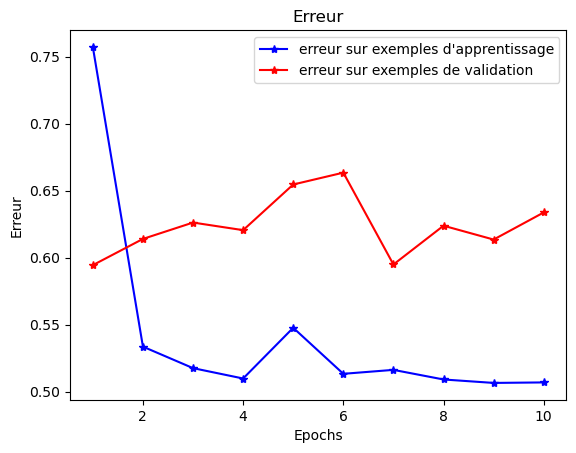

In [53]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

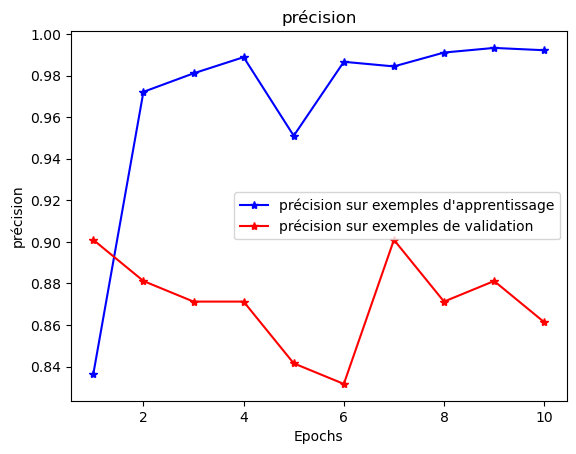

In [54]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

### Evaluer le modèle sur l'exemple d'entrainement

In [55]:
# evaluate
loss, acc = model.evaluate(xTest, yTest, verbose=0)
print('Précision sur exemples de test: %f' % (acc*100))

Précision sur exemples de test: 86.138612


---
### TensorBoard

Maintenant, <span style="background-color:yellow">utilisez un "TensorBoard"</span> pour représenter les courbes d'apprentissage..
(cf. exemple [Detection d'Alertes avec TensorBoard](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionDetectionAlertesTensorBoard.ipynb) )

(dupliquez votre fichier notebook pour en créer un nouveau)


---
## <span style="color:red;background-color:yellow">TRAVAIL A RENDRE</span>

* Vous devrez tester 5 différentes architectures de réseau (nb de couches), ainsi que différentes configurations (fonctions d'activation, méthodes de correction d'erreur, méthode de calcul de l'erreur)
* Tentez d'expliquez les différences de résultat
* les exemples de base sont trop important pour être tous intégrés en un seul cycle d'apprentissage. Proposez un soltion permettant d'utiliser totalement les données du fichier fourni.
* Vous enverrez un fichier pdf pour chaque configuration contenant les diagramme :
    * l'architecture du réseau (un copier coller du bloc 'TODO: définir la structure du réseau')
    * le déroulé de l'apprentissage (un copier coller du bloc résultat de 'TODO tester differents nb de tests (epochs)'
    * le résultat de 'Test Accuracy'

